# Logistic Regression Walkthrough
This notebook contains the code used in my Medium article. You can follow along the post with the cells in this notebook.

### 2. Breaking Down Logistic Regression
Load our packages.

In [1]:
# import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

import tensorflow as tf
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Dance to import our logit model
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from logistic_regression import LogisticRegression

### 3. Learning by Example with the UCI Heart Disease Dataset

In [2]:
# prepare the heart disease dataset

# Read the input data
df = pd.read_csv("heart.csv")

# The targets are inverted (0 - yes, 1 - no). Let's fix that
df.target = df.target.replace({0: 1, 1: 0})

# Print a summary
print(f"Number of subjects: {df.shape[0]}")
print("Subjects diagnosed with heart disease: "
      f"{df['target'].sum() / df.shape[0] * 100:0.2f}%")
print(f"Number of NaN values in the dataset: {df.isnull().sum().sum()}")

# Show the table
df.head()

Number of subjects: 303
Subjects diagnosed with heart disease: 45.54%
Number of NaN values in the dataset: 0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


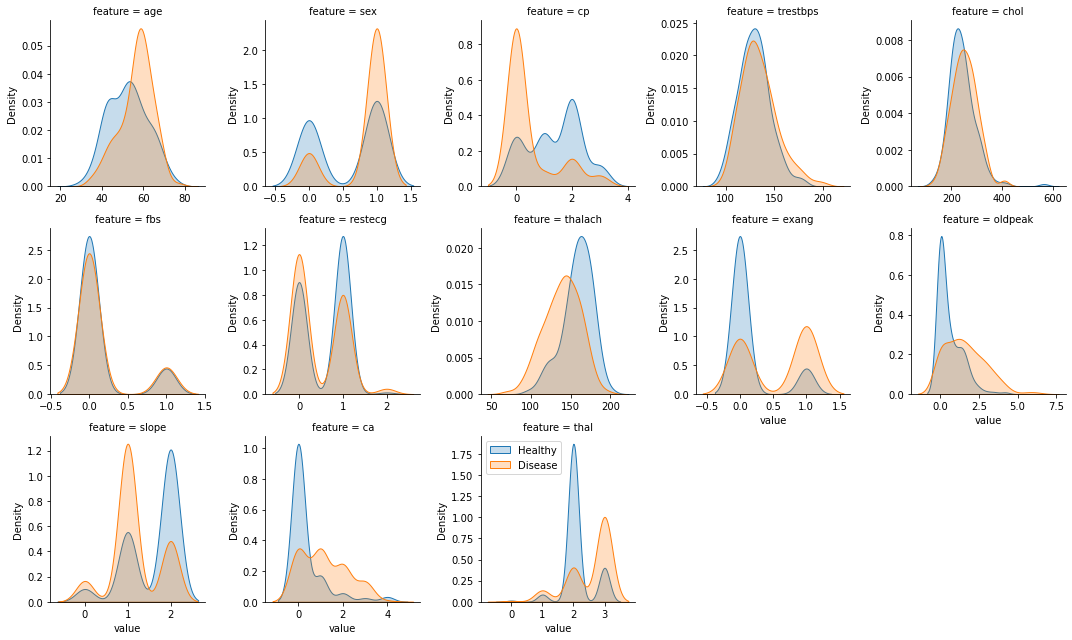

In [3]:
# Create a FacetGrid with SNS for a rough visualization
long_df = pd.melt(df, df.columns[-1], df.columns[:-1], var_name="feature")

g = sns.FacetGrid(long_df, col="feature", hue="target", 
                sharex=False, sharey=False, col_wrap=5, )
                # palette="flare")
g.map(sns.kdeplot, "value", shade=True)
plt.legend(labels=["Healthy", "Disease"], loc="upper left")
plt.show()

In [4]:
# Split the dataset into train/test datasets.
targets = df.pop("target")  # remove the target label from the dataframe

# create the test:train split
x_train, x_test, y_train, y_test = train_test_split(
    df, targets, test_size=0.25, random_state=42
)

# Normalize the continuous features, ignore discrete (here treat age as continuous)
features_to_standardize = ["age", "trestbps", "chol", "thalach", "oldpeak"]

column_transformer = ColumnTransformer(
    [("scaler", StandardScaler(), features_to_standardize)], remainder="passthrough"
)
x_train = column_transformer.fit_transform(x_train)
x_test = column_transformer.transform(x_test)

### 4. Training and Testing Our Classifier

Final model cost: 0.36              
Model test prediction accuracy: 86.84%


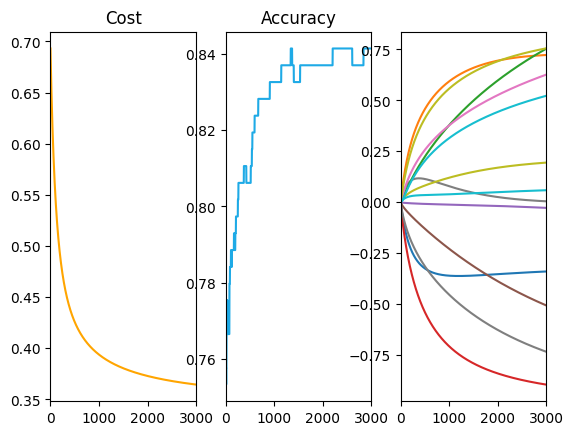

In [7]:
from celluloid import Camera

# Create and train the model
model = LogisticRegression(n_input_features=x_train.shape[-1])

costs, accuracies, weights, bias = model.train(x_train, y_train,
                    epochs=3000,
                    learning_rate=0.01,
                    minibatch_size=None,
                    verbose=True)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, )
# plt.subplots_adjust(wspace=0.25)
plt.xlim(0, costs.shape[0])
camera = Camera(fig)
for i in range(0, costs.shape[0], 20):
    ax0.set_title("Cost")
    ax0.plot(np.arange(0, i), costs[:i], color="orange")
    ax1.set_title("Accuracy")
    ax1.plot(np.arange(0, i), accuracies[:i]/100, color="#1eaae6")
    for j in range(weights[0].shape[0]):
        ax2.plot(np.arange(0, i), weights[:i, j])
    # plt.show()
    camera.snap()
    
animation = camera.animate()
animation.save("/Users/jacobbumgarner/Desktop/eg.mov", dpi=150, fps=60,
               progress_callback = lambda i, n: print(f'Saving frame {i} of {n}', end="\r"))

# Predict the test labels
predictions = model.predict(x_test)
accuracy = model.accuracy(predictions, y_test)
print(f"Model test prediction accuracy: {accuracy:0.2f}%")

